© 2025 Mobile Perception Systems Lab at TU/e. All rights reserved. Licensed under the MIT License.

## Setup

In [1]:
import yaml
from lightning import seed_everything
import torch
from torch.nn import functional as F
from torch.amp.autocast_mode import autocast
import matplotlib.pyplot as plt
import numpy as np
from huggingface_hub import hf_hub_download
from huggingface_hub.utils import RepositoryNotFoundError
import warnings
import importlib

seed_everything(0, verbose=False)

device = 0  # TODO: change to the GPU you want to use
img_idx = 0  # TODO: change to the index of the image you want to visualize
config_path = "/home/arda/thesis/eomt/configs/coco/instance/eomt_large_det_640.yaml"  # TODO: change to the config file
data_path = "data"  # TODO: change to the dataset directory

with open(config_path, "r") as f:
    config = yaml.safe_load(f)


def create_mapping(images, ignore_index):
    unique_ids = np.unique(np.concatenate([np.unique(img) for img in images]))
    valid_ids = unique_ids[unique_ids != ignore_index]
    colors = np.array([plt.cm.hsv(i / len(valid_ids))[:3] for i in range(len(valid_ids))])
    mapping = {cid: colors[i] for i, cid in enumerate(valid_ids)}
    mapping[ignore_index] = np.array([0, 0, 0])
    return mapping


def apply_colormap(image, mapping):
    colored_image = np.zeros((*image.shape, 3))
    for cid in np.unique(image):
        colored_image[image == cid] = mapping.get(cid, [0, 0, 0])
    return colored_image

/home/arda/miniconda3/envs/EoMT/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
config

{'trainer': {'max_epochs': 12,
  'check_val_every_n_epoch': 1,
  'logger': {'class_path': 'lightning.pytorch.loggers.wandb.WandbLogger',
   'init_args': {'resume': 'allow',
    'project': 'eomt',
    'name': 'coco_instance_eomt_large_640'}}},
 'model': {'class_path': 'training.mask_classification_detection_instance.MaskClassificationDetectionInstance',
  'init_args': {'attn_mask_annealing_enabled': True,
   'attn_mask_annealing_start_steps': [14782, 29564, 44346, 59128],
   'attn_mask_annealing_end_steps': [29564, 44346, 59128, 73910],
   'network': {'class_path': 'models.eomt.EoMT',
    'init_args': {'num_q': 200,
     'encoder': {'class_path': 'models.vit.ViT',
      'init_args': {'backbone_name': 'vit_large_patch14_reg4_dinov2'}}}}}},
 'data': {'class_path': 'datasets.coco_det.COCODetection',
  'init_args': {'img_size': [640, 640]}}}

## Load dataset

Ensure the dataset files are correctly prepared and placed in the folder specified by `data_path`.

In [3]:
data_module_name, class_name = config["data"]["class_path"].rsplit(".", 1)
data_module = getattr(importlib.import_module(data_module_name), class_name)

from datasets.coco_det import COCODetection
data_module = COCODetection
data_module_kwargs = config["data"].get("init_args", {})

data_module = COCODetection(
    path='data',
    batch_size=1,
    num_workers=0,
    check_empty_targets=False,
    **data_module_kwargs
)
data_module.setup()
data = data_module

In [4]:
data

## Load model

In [5]:
warnings.filterwarnings(
    "ignore",
    message=r".*Attribute 'network' is an instance of `nn\.Module` and is already saved during checkpointing.*",
)

# Load encoder
encoder_cfg = config["model"]["init_args"]["network"]["init_args"]["encoder"]
encoder_module_name, encoder_class_name = encoder_cfg["class_path"].rsplit(".", 1)
encoder_cls = getattr(importlib.import_module(encoder_module_name), encoder_class_name)
encoder = encoder_cls(img_size=[640,640], **encoder_cfg.get("init_args", {}))

# Load network
network_cfg = config["model"]["init_args"]["network"]
network_module_name, network_class_name = network_cfg["class_path"].rsplit(".", 1)
network_cls = getattr(importlib.import_module(network_module_name), network_class_name)
network_kwargs = {
    k: v for k, v in network_cfg["init_args"].items() if k != "encoder"
}
network = network_cls(
    masked_attn_enabled=False,
    num_classes=80,
    encoder=encoder,
    **network_kwargs,
)

# Load Lightning module
lit_module_name, lit_class_name = config["model"]["class_path"].rsplit(".", 1)
lit_cls = getattr(importlib.import_module(lit_module_name), lit_class_name)
model_kwargs = {
    k: v for k, v in config["model"]["init_args"].items() if k != "network"
}
if "stuff_classes" in config["data"].get("init_args", {}):
    model_kwargs["stuff_classes"] = config["data"]["init_args"]["stuff_classes"]

model = (
    lit_cls(
        img_size=[640,640],
        num_classes=80,
        network=network,
        **model_kwargs,
    )
    .eval()
    .to(device)
)

## Load pre-trained weights from Hugging Face Hub
The model weights are downloaded from the Hugging Face Hub using the logger name from the config. Make sure you have a working internet connection.

In [6]:
name = config.get("trainer", {}).get("logger", {}).get("init_args", {}).get("name")

if name is None:
    warnings.warn("No logger name found in the config. Please specify a model name.")
else:
    try:
        # state_dict_path = hf_hub_download(
        #     repo_id=f"tue-mps/{name}",
        #     filename="pytorch_model.bin",
        # )
        state_dict = torch.load(
            '/home/arda/thesis/eomt/eomt/eqar023k/checkpoints/epoch=11-step=87948.ckpt', map_location=torch.device(f"cuda:{device}"), weights_only=True
        )
        model.load_state_dict(state_dict['state_dict'])
    except RepositoryNotFoundError:
        warnings.warn(f"Pre-trained model not found for `{name}`. Please load your own checkpoint.")

## Semantic inference (pixel-wise classification)

> This inference method also works when applied to a model trained for panoptic segmentation.

Semantic inference computes per-pixel class scores by combining mask and class predictions:

$$
\sum_i p_i(c) \cdot m_i[h, w]
$$

Here, $p_i(c)$ is the class probability for class $c$ (excluding "no object"), and $m_i[h, w]$ is the sigmoid-normalized mask value for query $i$ at pixel $(h, w)$. The final class is selected by taking the argmax over classes.  
  
*This inference method was originally introduced in MaskFormer.*

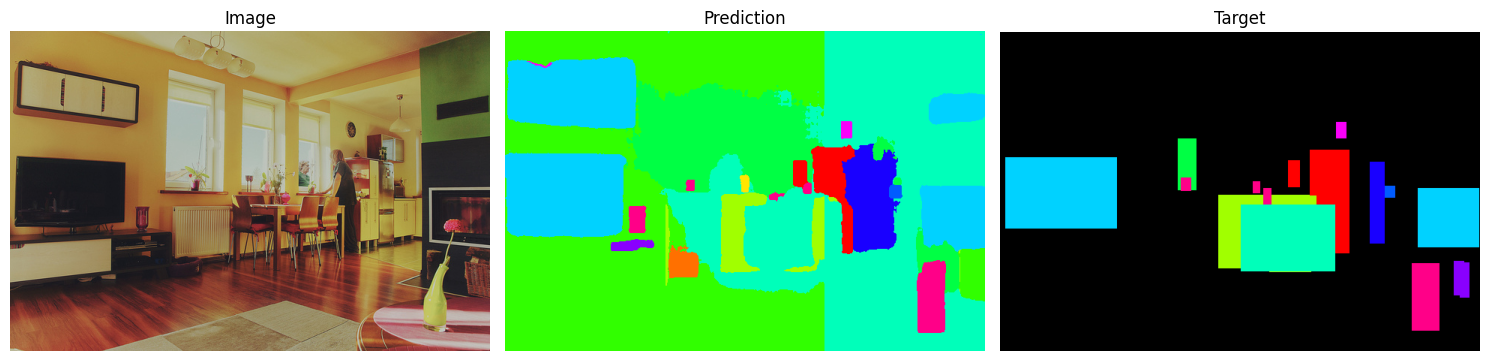

In [7]:
IGNORE_INDEX = 255


def infer_semantic(img, target):
    with torch.no_grad(), autocast(dtype=torch.float16, device_type="cuda"):
        imgs = [img.to(device)]
        img_sizes = [img.shape[-2:] for img in imgs]
        crops, origins = model.window_imgs_semantic(imgs)

        mask_logits_per_layer, class_logits_per_layer = model(crops)
        mask_logits = F.interpolate(mask_logits_per_layer[-1], data.img_size, mode="bilinear")

        crop_logits = model.to_per_pixel_logits_semantic(
            mask_logits, class_logits_per_layer[-1]
        )
        logits = model.revert_window_logits_semantic(crop_logits, origins, img_sizes)
        preds = logits[0].argmax(0).cpu()

    pred_array = preds.numpy()
    target_array = model.to_per_pixel_targets_semantic([target], IGNORE_INDEX)[0].numpy()
    return pred_array, target_array


def plot_semantic_results(img, pred_array, target_array):
    mapping = create_mapping([pred_array, target_array], IGNORE_INDEX)

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(img.permute(1, 2, 0).cpu().numpy())
    axes[0].set_title("Image")
    axes[1].imshow(apply_colormap(pred_array, mapping))
    axes[1].set_title("Prediction")
    axes[2].imshow(apply_colormap(target_array, mapping))
    axes[2].set_title("Target")

    for ax in axes:
        ax.axis("off")

    plt.tight_layout()
    plt.show()


img, target = data.val_dataloader().dataset[img_idx]
pred_array, target_array = infer_semantic(img, target)
plot_semantic_results(img, pred_array, target_array)

## Panoptic inference (segmentation with instance IDs)

> This inference method also works when applied to a model trained for instance segmentation.

Panoptic inference assigns each pixel $[h, w]$ to the query $i$ that maximizes the product of class and mask confidence:

$$
p_i(c_i) \cdot m_i[h, w]
$$

where $c_i = \arg\max_c \, p_i(c)$ is the most likely class for query $i$. A pixel is assigned to a query only if both the class confidence and mask confidence are high. Pixels assigned to the same query form a segment labeled with $c_i$. "Stuff" segments with the same class are merged; "thing" segments are kept distinct using the query index. Low-confidence and heavily occluded predictions are filtered out.  
  
*This inference method was originally introduced in MaskFormer.*

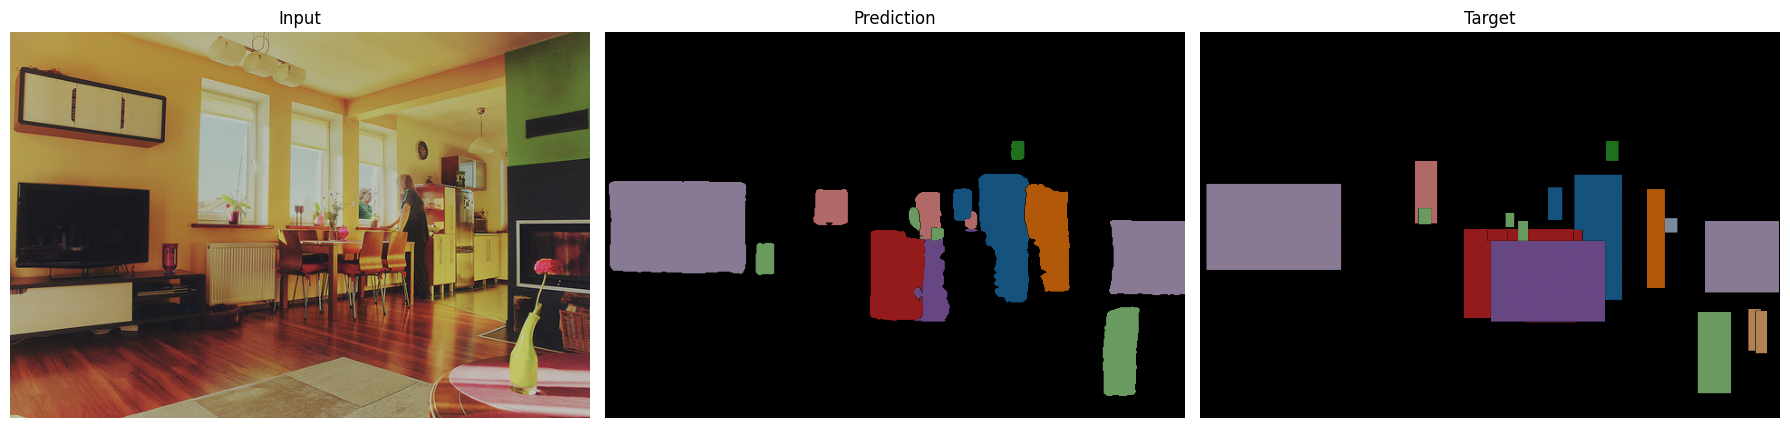

In [56]:
def infer_panoptic(img, target):
    with torch.no_grad(), autocast(dtype=torch.float16, device_type="cuda"):
        imgs = [img.to(device)]
        img_sizes = [img.shape[-2:] for img in imgs]

        transformed_imgs = model.resize_and_pad_imgs_instance_panoptic(imgs)
        mask_logits_per_layer, class_logits_per_layer = model(transformed_imgs)
        mask_logits = F.interpolate(mask_logits_per_layer[-1], model.img_size, mode="bilinear")
        mask_logits = model.revert_resize_and_pad_logits_instance_panoptic(mask_logits, img_sizes)

        preds = model.to_per_pixel_preds_panoptic(
            mask_logits,
            class_logits_per_layer[-1],
            model.stuff_classes,
            model.mask_thresh,
            model.overlap_thresh,
        )[0].cpu()

    pred = preds.numpy()
    sem_pred, inst_pred = pred[..., 0], pred[..., 1]

    target_seg = model.to_per_pixel_targets_panoptic([target])[0].cpu().numpy()
    sem_target, inst_target = target_seg[..., 0], target_seg[..., 1]
    
    # Extract individual instance masks
    def extract_instance_masks(sem_mask, inst_mask):
        # Get unique semantic and instance IDs (excluding background)
        sem_ids = np.unique(sem_mask)
        inst_ids = np.unique(inst_mask)
        sem_ids = sem_ids[sem_ids != -1]  # Remove background
        inst_ids = inst_ids[inst_ids != -1]  # Remove background
        
        instance_masks = []
        class_ids = []
        
        # For each instance ID, create a binary mask
        for inst_id in inst_ids:
            # Get the corresponding semantic class for this instance
            inst_pixels = inst_mask == inst_id
            if np.any(inst_pixels):
                # Most common semantic class in this instance
                class_id = np.bincount(sem_mask[inst_pixels].astype(int)).argmax()
                
                # Create a mask with just this instance
                mask = np.zeros_like(inst_mask)
                mask[inst_mask == inst_id] = 1
                
                instance_masks.append(mask)
                class_ids.append(class_id)
        
        return instance_masks, class_ids
    
    # Extract instance masks and classes
    pred_instance_masks, pred_class_ids = extract_instance_masks(sem_pred, inst_pred)
    target_instance_masks, target_class_ids = extract_instance_masks(sem_target, inst_target)
    
    return {
        'image': img.cpu(),
        'pred_instances': pred_instance_masks,
        'pred_classes': pred_class_ids,
        'target_instances': target_instance_masks,
        'target_classes': target_class_ids,
        'sem_pred': sem_pred,
        'sem_target': sem_target
    }


def draw_black_border(sem, inst, mapping):
    h, w = sem.shape
    out = np.zeros((h, w, 3))
    for s in np.unique(sem):
        out[sem == s] = mapping[s]

    combined = sem.astype(np.int64) * 100000 + inst.astype(np.int64)
    border = np.zeros((h, w), dtype=bool)
    border[1:, :] |= combined[1:, :] != combined[:-1, :]
    border[:-1, :] |= combined[1:, :] != combined[:-1, :]
    border[:, 1:] |= combined[:, 1:] != combined[:, :-1]
    border[:, :-1] |= combined[:, 1:] != combined[:, :-1]
    out[border] = 0
    return out


def plot_panoptic_results(results):
    img = results['image']
    pred_instances = results['pred_instances']
    pred_classes = results['pred_classes']
    target_instances = results['target_instances']
    target_classes = results['target_classes']
    
    # Create a figure with subplots
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    
    # Plot original image
    axs[0].imshow(img.permute(1, 2, 0).numpy())
    axs[0].set_title('Input')
    axs[0].axis('off')
    
    # Create a color map for semantic classes
    all_classes = set(pred_classes + target_classes)
    class_to_color = {cls_id: plt.cm.tab20(i % 20) for i, cls_id in enumerate(all_classes)}
    
    # Plot prediction instances
    axs[1].imshow(np.zeros_like(pred_instances[0] if pred_instances else np.zeros((img.shape[1], img.shape[2]))), cmap='gray')
    for mask, class_id in zip(pred_instances, pred_classes):
        color = class_to_color[class_id]
        colored_mask = np.zeros((*mask.shape, 4))
        colored_mask[mask == 1] = color
        axs[1].imshow(colored_mask, alpha=0.7)
    axs[1].set_title('Prediction')
    axs[1].axis('off')
    
    # Plot target instances
    axs[2].imshow(np.zeros_like(target_instances[0] if target_instances else np.zeros((img.shape[1], img.shape[2]))), cmap='gray')
    for mask, class_id in zip(target_instances, target_classes):
        color = class_to_color[class_id]
        colored_mask = np.zeros((*mask.shape, 4))
        colored_mask[mask == 1] = color
        axs[2].imshow(colored_mask, alpha=0.7)
    axs[2].set_title('Target')
    axs[2].axis('off')
    
    plt.tight_layout()
    plt.show()


img, target = data.val_dataloader().dataset[0]
res = infer_panoptic(img, target)
plot_panoptic_results(res)

In [ ]:
python main.py fit \
  -c /home/arda/thesis/eomt/configs/ade20k/panoptic/eomt_large_640.yaml \
  --trainer.devices 2 \
  --data.batch_size 8 \
  --data.path data \
  --model.ckpt_path /home/arda/thesis/eomt/checkpoints/COCO_panoptic_640.bin \
  --model.load_ckpt_class_head False